Upload

1.   pricing config json




In [85]:
import numpy as np
import matplotlib.pyplot as plt


### Project Environment

In [86]:
import json
import numpy as np
import math
import os 

class contextEnv():
    
    def __init__(self):
        # dirname = os.path.dirname(__file__)
        path = 'pricing_config.json'
        with open(path) as json_file:
            data = json.load(json_file)
        self.name=data["product"][0]["name"]
        self.features=data["product"][0]["features"]
        self.classes=data["product"][0]["classes"]
        self.prices=data["product"][0]["prices"]
        self.probabilities=data["product"][0]["probabilities"]
        
    def nextTimeProbability(month):
        return(month/(2+month))
    
    def nrDailyClick(bid):
        meanNrClick = math.trunc(500*math.tanh(bid))
        nrClick= math.trunc(np.random.uniform(meanNrClick-0.05*meanNrClick, meanNrClick+0.05*meanNrClick,1))
        return nrClick
    
    def costPerClick(self, bid):
        s= np.random.uniform(bid-0.05*bid, bid+0.05*bid,1)
        return s
        
    def conversionRateFunctionMale(price):
        rate=0.0001*(price)^3-0.0072*(price)^2+0.0842*price +0.3294
        return rate
    
    def conversionRateFunctionFelameA(price):
        rate= 0.0001*(price)^3-0.0053*(price)^2+0.0988*price+0.1855
        return rate
    
    def conversionRateFunctionFemaleY(price):
        rate=0.0001*(price)^3-0.0074*(price)^2+0.0804*price+0.3241
        return rate
   

### Bidding Environment

In [87]:
class Learner:
    def __init__(self, n_arms):
        self.n_arms = n_arms
        self.t = 0
        self.rewards_per_arm = x = [[] for i in range(0, n_arms)]
        self.collected_rewards = np.array([])
    
    def update_observations(self, pulled_arm, reward):
        self.rewards_per_arm[pulled_arm].append(reward)
        self.collected_rewards = np.append(self.collected_rewards, reward)

In [100]:
def fun(bid):
    meanNrClick = math.trunc(500*math.tanh(bid))
    nrClick= math.trunc(np.random.uniform(meanNrClick-0.05*meanNrClick, meanNrClick+0.05*meanNrClick,1)[0])
    return nrClick

class BiddingEnvironment():
    def __init__(self, bids, sigma): #array of possible bids and (sigma) standard deviation of the reward function and we assume.
        self.bids = bids
        self.means = [fun(bid) for bid in bids] #mean of reward function
        self.sigmas = np.ones(len(bids)) * sigma

    def round(self, pulled_arm):
        reward = np.random.normal(self.means[pulled_arm], self.sigmas[pulled_arm], 1)
        return reward

In [111]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

class GPTS_Learner(Learner):
    def __init__(self, n_arms, arms):
        super().__init__(n_arms)
        self.arms = arms
        self.means = np.zeros(n_arms)
        self.sigmas = np.ones(n_arms) * 10
        self.revenue_probs = np.zeros(10)
        self.pulled_arms = []
        alpha = 10.0
        kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-3, 1e3))
        self.gp = GaussianProcessRegressor(kernel=kernel, alpha = alpha**2, normalize_y=True, n_restarts_optimizer=10)

    
    def update_observations(self, pulled_arm, reward):
        super().update_observations(pulled_arm, reward)
        self.pulled_arms.append(self.arms[pulled_arm])
        
    def update_model(self):
        x = np.atleast_2d(self.pulled_arms).T
        y = self.collected_rewards
        self.gp.fit(x,y)
        
        x_pred = np.atleast_2d(self.arms).T
        self.means, self.sigmas = self.gp.predict(x_pred, return_std=True)
        self.sigmas = np.maximum(self.sigmas, 1e-2)
        
    def update(self, pulled_arm, reward):
        self.t += 1
        self.update_observations(pulled_arm, reward)
        self.update_model()
        
    
    def pull_arm(self):
        bool_arr = self.revenue_probs < 0.20
        idxs = np.where(bool_arr)[0]
        ms = [self.means[i] for i in idxs]
        sigs = [self.sigmas[i] for i in idxs]
        idx = np.argmax(np.random.normal(ms, sigs))
        return idxs[idx]

In [112]:
class GTS_Learner(Learner):
    def __init__(self, n_arms):
        super().__init__(n_arms)
        self.means = np.zeros(n_arms)
        self.sigmas = np.ones(n_arms) * 1e3
        self.revenue_probs = np.zeros(n_arms)

        
    def pull_arm(self):
        bool_arr = self.revenue_probs < 0.20
        idxs = np.where(bool_arr)[0]
        ms = [self.means[i] for i in idxs]
        sigs = [self.sigmas[i] for i in idxs]
        idx = np.argmax(np.random.normal(ms, sigs))
        return idxs[idx]
    
     
    def update(self, pulled_arm, reward):
        self.t += 1
        self.update_observations(pulled_arm, reward)
        self.means[pulled_arm] = np.mean(self.rewards_per_arm[pulled_arm])
        n_samples = len(self.rewards_per_arm[pulled_arm])
        if n_samples > 1:
            self.sigmas[pulled_arm] = np.std(self.rewards_per_arm[pulled_arm]) / n_samples


### Pricing Enviroment

In [93]:
class Enviroment():
    def __init__(self, n_arms, probabilities):
        self.narms = n_arms
        self.probabilities = probabilities
    
    def round(self, pulled_arm):
        reward = np.random.binomial(1, self.probabilities[pulled_arm])
        return reward

In [94]:
class PricingLearner:
    def __init__(self, n_arms):
        self.n_arms=n_arms
        self.t=0 #current round value, cioè il tempo t, inizializzato a 0
        #questa variabile è una lista di liste e la dimensione della lista esterna
        #è uguale al numero di arms mentre la dimensione della lista interna è data
        #da quante volte ho pullato una determinata arm 
        self.rewards_per_arm= x = [ [] for i in range (n_arms)]
        self. collected_rewards = np.array([])
    
    def update_observations(self, pulled_arm, reward):
        #quando ho pullato l'arm inserisco i valori ottenuti
        self.rewards_per_arm[pulled_arm].append(reward) 
        self.collected_rewards= np.append(self.collected_rewards, reward)

In [95]:
class TS_Learner(PricingLearner):
    def __init__(self, n_arms):
        super().__init__(n_arms)
        #estendo la classe learner precedente con il parametro dela beta distribution
        self.beta_parameters = np.ones((n_arms, 2)) #i parametri della beta distribution sono due
        #alpha e beta ed entrambi inizialmente sono inizializzati a 1, per quest creo un nuovo array 
        #bidimensionale di 1 con lunghezza = al numero di arms
        
    def pull_arm(self):
        #per ogni arm quello che faccio è di prendere un sample dalla beta distribution per ogni arm 
        #ad ogni iterazione. L'arm che verrà pullata sarà quella con il sample con il valore maggiore
        #in questo caso infatti per ogni arm tramite la funzione np.random.beta creo dei sample e con la
        #funzione argmax seleziono l'indice di quello con il valore maggiore
        idx=np.argmax(np.random.beta(self.beta_parameters[:,0], self.beta_parameters[:,1]))
        return idx
    
    def update(self, pulled_arm, reward):
        self.t+=1; #incremento il tempo
        self.update_observations(pulled_arm, reward) #faccio l'update delle observation
        self.beta_parameters[pulled_arm, 0]= self.beta_parameters[pulled_arm,0]+reward
        self.beta_parameters[pulled_arm, 1]= self.beta_parameters[pulled_arm,1] +(1.0 - reward)

In [96]:
class UCB1(PricingLearner):
    def __init__(self, n_arms):
        super().__init__(n_arms)
        self.empirical_means= np.zeros(n_arms) #Xa
        self.confidence = np.zeros(n_arms) #extra term (quello sotto radice)
    
    def pull_arm(self): #pull the arm that maximixe the bound (see the formula)
        if self.t< self.n_arms:
            arm=self.t
        else:  
            upper_bound=self.empirical_means+self.confidence
            arm=np.random.choice(np.where(upper_bound==upper_bound.max())[0])
        return arm
         
    def update(self, pulled_arm, reward):
        self.t +=1        
        #self.collected_rewards= np.append(self.collected_rewards, reward)
        self.empirical_means[pulled_arm]=(self.empirical_means[pulled_arm]*(self.t-1)+reward)/self.t
        for a in range (self.n_arms):
            number_pulled= max(1, len(self.rewards_per_arm[a]))
            self.confidence[a]=(2*np.log(self.t)/number_pulled)**0.5
            
        self.update_observations(pulled_arm, reward)

### Step 3

638207.0
449568.0


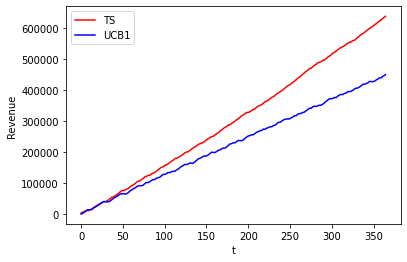

In [106]:
context= contextEnv()
prezzi=context.prices
min_prezzo= np.min(prezzi)
max_prezzo= np.max(prezzi)

p=context.probabilities
c=np.zeros(10)

for i in range(0,9):
    c[i]=(p[0][i]+p[1][i]+p[2][i])/3

opt=np.max(c)
n_arms=10;
T=365

fixedBid=1.0
totalRevenueTS=[]
totalRevenueUCB1=[]
dailyTS=0
dailyUCB1=0

cumRewardTS=0
cumRewardUCB1=0
nrClick=380
costPerClick=1.0
env = Enviroment(n_arms= n_arms, probabilities=c)
ts_learner= TS_Learner(n_arms=n_arms)
ucb1_learner= UCB1(n_arms= n_arms)
for t in range (0,T):
    #pull TS arm
    pulled_armTS=ts_learner.pull_arm() #prendo l'arm

    #pull UCB1 arm
    pulled_armUCB1=ucb1_learner.pull_arm()
    
    #I pull a new arm every day, and i propose the same price to the same person
    
    for c in range(0, nrClick):
        #Thompson Sampling Learner
        
        reward= env.round(pulled_armTS) #calcolo il reward
        cumRewardTS+=reward*(prezzi[pulled_armTS]/max_prezzo)
        dailyTS+=reward*prezzi[pulled_armTS]-costPerClick
        
        
        #totalRevenueTS=totalRevenueTS.append(prezzi[pulled_arm])
        #ts_learner.update(pulled_arm, reward)
        
        
        #UCB1 Learner 
        
        reward=env.round(pulled_armUCB1)
        cumRewardUCB1+=reward*(prezzi[pulled_armTS]/max_prezzo)
        dailyUCB1+=reward*prezzi[pulled_armUCB1]-costPerClick
        #totalRevenueUCB1=totalRevenueUCB1.append(prezzi[pulled_arm])
        #ucb1_learner.update(pulled_arm, reward)
    
    
    #make the average of the cumulative reward 
    totalRevenueTS.append(dailyTS)
    totalRevenueUCB1.append(dailyUCB1)
    #print(totalRevenueTS[t])
    #print(totalRevenueUCB1[t])
    ts_learner.update(pulled_armTS,cumRewardTS/nrClick)
    ucb1_learner.update(pulled_armUCB1, cumRewardUCB1/nrClick)
    dailyTS=0
    dailyUCB1=0
    cumRewardTS=0
    cumRewardUCB1=0


print(np.cumsum(totalRevenueTS)[364])
print(np.cumsum(totalRevenueUCB1)[364])



plt.figure(0)
plt.xlabel("t")
plt.ylabel("Revenue")
plt.plot(np.cumsum(totalRevenueTS, axis=0), 'r')
plt.plot(np.cumsum(totalRevenueUCB1, axis=0), 'b')
plt.legend(["TS", "UCB1"])





plt.show()


### Step 4

720508.0
640421.0


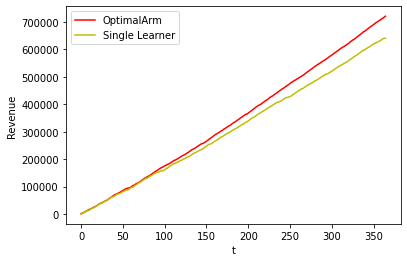

In [107]:
context= contextEnv()
prezzi=context.prices



p=context.probabilities

fixedBid=1.0
costPerClick=1.0


optClass1=np.max(p[0])
optClass2=np.max(p[1])
optClass3=np.max(p[2])

max_prezzo= np.max(prezzi)


n_arms=10;
T=365




totalRevenueTS=[]


totalRevenueSingle=[]


#reward if for every class i use his optimal arm
dailyTS=0

dailyTSSingle=0


cumRewardTSC1=0
cumRewardTSC2=0
cumRewardTSC3=0
cumRewardSingle=0

nrClickPerClass=127


#for each class define a new enviroment with his respective probabilities
envClass1 = Enviroment(n_arms= n_arms, probabilities=p[0])
envClass2 = Enviroment(n_arms= n_arms, probabilities=p[1])
envClass3 = Enviroment(n_arms= n_arms, probabilities=p[2])

#for every class define 3 different TS learner
ts_learnerClass1= TS_Learner(n_arms=n_arms)
ts_learnerClass2= TS_Learner(n_arms=n_arms)
ts_learnerClass3= TS_Learner(n_arms=n_arms)

ts_learnerSingle =TS_Learner(n_arms=n_arms)



for t in range (0,T):
    
    
    #pull TS arms
    pulled_armC1=ts_learnerClass1.pull_arm() 
    pulled_armC2=ts_learnerClass2.pull_arm() 
    pulled_armC3=ts_learnerClass3.pull_arm() 
    pulled_armSingle=ts_learnerSingle.pull_arm()
    
    
    
    
    #I pull a new arm every day, and i can distinguish the three different
    #class, and propose to each of them a different class
    
    #Class 1
    
    for x in range(0, nrClickPerClass):
        #Getting reward from his best arm
        reward= envClass1.round(pulled_armC1) #calcolo il reward
        cumRewardTSC1+=reward*(prezzi[pulled_armC1]/max_prezzo)
        dailyTS+=reward*prezzi[pulled_armC1]-costPerClick
    
        #using single learner
 
        reward= envClass1.round(pulled_armSingle)    
        dailyTSSingle+= reward*prezzi[pulled_armSingle]-costPerClick
        cumRewardSingle+=reward*(prezzi[pulled_armSingle]/max_prezzo)
    
    
        
    #Class 2
    for x in range(0, nrClickPerClass):
        #Getting reward from his best arm
        reward= envClass2.round(pulled_armC2) #calcolo il reward
        cumRewardTSC2+=reward*(prezzi[pulled_armC2]/max_prezzo)
        dailyTS+=reward*prezzi[pulled_armC2]-costPerClick
               
               
        #using single learner
        
        reward= envClass2.round(pulled_armSingle)
        dailyTSSingle+= reward*prezzi[pulled_armSingle]-costPerClick
        cumRewardSingle+=reward*(prezzi[pulled_armSingle]/max_prezzo)
        
     
    #Class 3
    for x in range(0, nrClickPerClass):
        #Getting reward from his best arm
        reward= envClass3.round(pulled_armC3) #calcolo il reward
        cumRewardTSC3+=reward*(prezzi[pulled_armC3]/max_prezzo)
        dailyTS+=reward*prezzi[pulled_armC3]-costPerClick
                
        
        #using single learner
        
        reward= envClass3.round(pulled_armSingle)
        dailyTSSingle+= reward*prezzi[pulled_armSingle]-costPerClick
        cumRewardSingle+=reward*(prezzi[pulled_armSingle]/max_prezzo)
    
    
    #make the average of the cumulative reward 
    totalRevenueTS.append(dailyTS)
    totalRevenueSingle.append(dailyTSSingle)
    
    
    
    ts_learnerClass1.update(pulled_armC1,cumRewardTSC1/nrClickPerClass)
    ts_learnerClass2.update(pulled_armC2,cumRewardTSC2/nrClickPerClass)
    ts_learnerClass3.update(pulled_armC3,cumRewardTSC3/nrClickPerClass)
    ts_learnerSingle.update(pulled_armSingle, cumRewardSingle/(3*nrClickPerClass))
    
    
    
    cumRewardTSC1=0
    cumRewardTSC2=0
    cumRewardTSC3=0
    cumRewardSingle=0
    

    dailyTS=0
    dailyTSSingle=0

print(np.cumsum(totalRevenueTS, axis=0)[364])
print(np.cumsum(totalRevenueSingle, axis=0)[364])




plt.figure(0)
plt.xlabel("t")
plt.ylabel("Revenue")
plt.plot(np.cumsum(totalRevenueTS, axis=0), 'r')
plt.plot(np.cumsum(totalRevenueSingle, axis=0), 'y')
plt.legend(["OptimalArm", "Single Learner"])



plt.show()


### Step 5 GTS

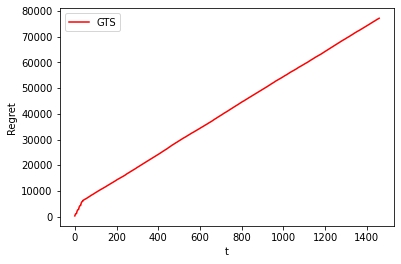

In [115]:
n_arms = 10
min_bid = 0.0
max_bid = 1.0
bids = np.linspace(min_bid, max_bid, n_arms)
sigma = 10

context = contextEnv()
fixed_price = np.mean(context.prices)
profit_margin = fixed_price * 0.15
conv_prob = np.mean(sum(context.probabilities, []))
rp = np.zeros(10)
rn = np.zeros(10)

T = 365
gts_rewards_per_experiment = []
env = BiddingEnvironment(bids=bids, sigma=sigma)
gts_learner = GTS_Learner(n_arms=n_arms)
u_idx = 0
for i in range(0,10):
    for j in range(0,4):
        reward = env.round(u_idx)
        u_idx += 1
        u_idx = u_idx % 10
        pulled_arm = u_idx
        reward = env.round(pulled_arm)
        nof = reward * conv_prob
        cost = context.costPerClick(env.bids[pulled_arm]) * reward
        profit = profit_margin * nof
        if(profit > cost):
            rp[pulled_arm] += 1
            gts_learner.revenue_probs[pulled_arm] = (rn[pulled_arm]) /  (rp[pulled_arm] + rn[pulled_arm])
        else: 
            rn[pulled_arm] += 1
            gts_learner.revenue_probs[pulled_arm] = (rn[pulled_arm]) /  (rp[pulled_arm] + rn[pulled_arm])

        gts_learner.update(pulled_arm, reward) 


for t in range(10, T):   
    for j in range(0,4):
        #Gaussian Process Thompson Sampling Learner
        pulled_arm = gts_learner.pull_arm()
        reward = env.round(pulled_arm)
        nof = reward * conv_prob
        cost = context.costPerClick(env.bids[pulled_arm]) * reward
        profit = profit_margin * nof 
        if(profit > cost):
            rp[pulled_arm] += 1
            gts_learner.revenue_probs[pulled_arm] = (rn[pulled_arm]) /  (rp[pulled_arm] + rn[pulled_arm])
        else: 
            rn[pulled_arm] += 1
            gts_learner.revenue_probs[pulled_arm] = (rn[pulled_arm]) /  (rp[pulled_arm] + rn[pulled_arm])
        
        gts_learner.update(pulled_arm, reward)

gts_rewards_per_experiment.append(gts_learner.collected_rewards)

opt = np.max(env.means)
plt.figure(0)
plt.xlabel("t")
plt.ylabel("Regret")
plt.plot(np.cumsum(np.mean(opt - gts_rewards_per_experiment, axis=0)), 'r')
plt.legend(["GTS"])
plt.show()

### Step 5 GPTS

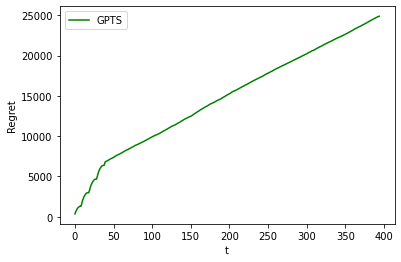

In [102]:
context = contextEnv()
fixed_price = np.mean(context.prices)
profit_margin = fixed_price * 0.15
conv_prob = np.mean(sum(context.probabilities, []))
rp = np.zeros(10)
rn = np.zeros(10)

T = 365
n_experiment = 10
gpts_rewards_per_experiment = []    


env = BiddingEnvironment(bids=bids, sigma=sigma)
gpts_learner = GPTS_Learner(n_arms=n_arms, arms=bids)
u_idx = 0

for i in range(0,10):
    for i in range(0,4):
        reward = env.round(u_idx)
        u_idx += 1
        u_idx = u_idx % 10
        pulled_arm = u_idx
        reward = env.round(pulled_arm)
        nof = reward * conv_prob
        cost = context.costPerClick(env.bids[pulled_arm]) * nof
        profit = profit_margin * nof
        if(profit > cost):
            rp[pulled_arm] += 1
            gpts_learner.revenue_probs[pulled_arm] = (rp[pulled_arm]) /  (rp[pulled_arm] + rn[pulled_arm])
        else: 
            rn[pulled_arm] += 1
            gpts_learner.revenue_probs[pulled_arm] = (rp[pulled_arm]) /  (rp[pulled_arm] + rn[pulled_arm] + 1)

        gpts_learner.update(pulled_arm, reward) 


for t in range(10, T):   
    #Gaussian Process Thompson Sampling Learner
    pulled_arm = gts_learner.pull_arm()
    reward = env.round(pulled_arm)
    nof = reward * conv_prob
    cost = context.costPerClick(env.bids[pulled_arm]) * nof
    price = profit_margin * nof
    if(profit > cost):
        rp[pulled_arm] += 1
        gpts_learner.revenue_probs[pulled_arm] = (rp[pulled_arm]) /  (rp[pulled_arm] + rn[pulled_arm])
    else: 
        rn[pulled_arm] += 1
        gpts_learner.revenue_probs[pulled_arm] = (rp[pulled_arm]) /  (rp[pulled_arm] + rn[pulled_arm])
    gpts_learner.update(pulled_arm, reward)
    
    
    
gpts_rewards_per_experiment.append(gpts_learner.collected_rewards)


opt = np.max(env.means)
plt.figure(0)
plt.xlabel("t")
plt.ylabel("Regret")
plt.plot(np.cumsum(np.mean(opt - gpts_rewards_per_experiment, axis=0)), 'g')
plt.legend(["GPTS"])
plt.show()

### Step 6

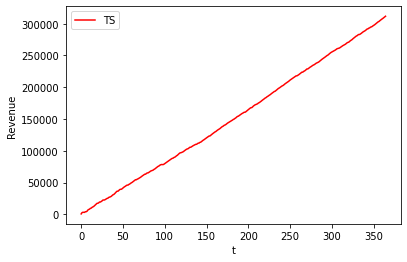

In [113]:
context = contextEnv()
prices = context.prices
probs = context.probabilities
max_price = np.max(prices)
cum_probs = np.zeros(10)
for i in range(0,9):
    cum_probs[i] = (probs[0][i] + probs[1][i] + probs[2][i]) / 3

n_arms = 10
T_days = 365

ts_rewards = []
totalRevenueTS = []
dailyTS = 0
cum_rewardTS = 0 


min_bid = 0.0
max_bid = 1.0
bids = np.linspace(min_bid, max_bid, n_arms)
sigma = 10
profit_margin = 0.15
rp = np.zeros(n_arms)
rn = np.zeros(n_arms)


p_env = Enviroment(n_arms = n_arms, probabilities = cum_probs)
b_env = BiddingEnvironment(bids=bids, sigma=sigma)
ts_learner = TS_Learner(n_arms = n_arms)
gpts_learner = GPTS_Learner(n_arms=n_arms, arms=bids)


for t in range(0, T_days):
    pulled_bid_arm = gpts_learner.pull_arm()
    bid_reward = b_env.round(pulled_bid_arm)
    
    pulled_price_arm = ts_learner.pull_arm()
    no_of_clicks = bid_reward * cum_probs[pulled_price_arm]
    cost_per_click = context.costPerClick(bids[pulled_bid_arm])

    for k in range(0, int(bid_reward)):
        price_reward = p_env.round(pulled_price_arm)
        cum_rewardTS += price_reward * (prices[pulled_price_arm] / max_price)
        dailyTS += price_reward * prices[pulled_price_arm] - cost_per_click
    
    totalRevenueTS.append(dailyTS)
    ts_rewards.append(cum_rewardTS / int(bid_reward))
    ts_learner.update(pulled_price_arm , cum_rewardTS / int(bid_reward))
    dailyTS = 0
    cum_rewardTS = 0

    profit = prices[pulled_price_arm] * profit_margin * no_of_clicks
    if(profit > (cost_per_click * bid_reward)):
        rp[pulled_bid_arm] += 1
        gpts_learner.revenue_probs[pulled_bid_arm] = (rn[pulled_bid_arm]) /  (rp[pulled_bid_arm] + rn[pulled_bid_arm])
    else: 
        rn[pulled_bid_arm] += 1
        gpts_learner.revenue_probs[pulled_bid_arm] = (rn[pulled_bid_arm]) /  (rp[pulled_bid_arm] + rn[pulled_bid_arm])
    gpts_learner.update(pulled_bid_arm, no_of_clicks)



plt.figure(0)
plt.xlabel("t")
plt.ylabel("Revenue")
plt.plot(np.cumsum(totalRevenueTS, axis=0), 'r')
plt.legend(["TS"])
plt.show()

### Step 7

[821796.33217462]
[691696.33217462]


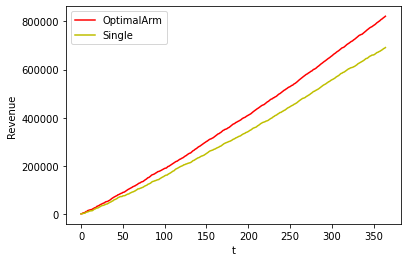

In [114]:
context= contextEnv()
prices = context.prices
max_price = np.max(prices)



probs = context.probabilities
# fixedBid = 1.0

optClass1 = np.max(probs[0])
optClass2 = np.max(probs[1])
optClass3 = np.max(probs[2])

n_arms = 10;
T = 365

ts_rewardsC1 = [] 
ts_rewardsC2 = [] 
ts_rewardsC3 = [] 

totalRevenueTS = []
totalRevenueSingle = []

dailyTS = 0
dailyTSSingle = 0


cumRewardTSC1 = 0
cumRewardTSC2 = 0 
cumRewardTSC3 = 0
cumRewardSingle = 0

min_bid = 0.0
max_bid = 1.0
bids = np.linspace(min_bid, max_bid, n_arms)
sigma = 10
profit_margin = 0.15
rp = np.zeros(n_arms)
rn = np.zeros(n_arms)

# nrClickPerClass=167


#for each class define a new enviroment with his respective probabilities
p_envClass1 = Enviroment(n_arms = n_arms, probabilities = probs[0])
p_envClass2 = Enviroment(n_arms = n_arms, probabilities = probs[1])
p_envClass3 = Enviroment(n_arms = n_arms, probabilities = probs[2])

# b_envClass1 = BiddingEnvironment(bids = bids, sigma = sigma)
# b_envClass2 = BiddingEnvironment(bids = bids, sigma = sigma)
# b_envClass3 = BiddingEnvironment(bids = bids, sigma = sigma)

b_env = BiddingEnvironment(bids = bids, sigma = sigma)

#for every class define 3 different TS learner
ts_learnerClass1 = TS_Learner(n_arms = n_arms)
ts_learnerClass2 = TS_Learner(n_arms = n_arms)
ts_learnerClass3 = TS_Learner(n_arms = n_arms)

ts_learnerSingle = TS_Learner(n_arms = n_arms)

# gts_learner1 = GTS_Learner(n_arms=n_arms, arms=bids)
# gts_learner2 = GTS_Learner(n_arms=n_arms, arms=bids)
# gts_learner3 = GTS_Learner(n_arms=n_arms, arms=bids)

gts_learner = GTS_Learner(n_arms=n_arms)



for t in range (0,T):
    
    
    #pull TS arms
    p_pulled_armC1 = ts_learnerClass1.pull_arm() 
    p_pulled_armC2 = ts_learnerClass2.pull_arm() 
    p_pulled_armC3 = ts_learnerClass3.pull_arm() 
    p_pulled_armSingle = ts_learnerSingle.pull_arm()

    # b_pulled_armC1 = gts_learner1.pull_arm()
    # b_pulled_armC2 = gts_learner2.pull_arm()
    # b_pulled_armC3 = gts_learner3.pull_arm()
    # b_pulled_armSingle = gts_learnerSingle.pull_arm()
    b_pulled_arm = gts_learner.pull_arm()

    # bid_reward1 = b_envClass1.round(b_pulled_armC1)
    # bid_reward2 = b_envClass2.round(b_pulled_armC2)
    # bid_reward3 = b_envClass3.round(b_pulled_armC3)
    
    bid_reward = b_env.round(b_pulled_arm)


    no_of_clicks1 = int(bid_reward * probs[0][p_pulled_armC1]) + 1
    no_of_clicks2 = int(bid_reward * probs[1][p_pulled_armC2]) + 1
    no_of_clicks3 = int(bid_reward * probs[2][p_pulled_armC3]) + 1
    

    cost_per_click = context.costPerClick(bids[b_pulled_arm])
    
    #I pull a new arm every day, and i can distinguish the three different
    #class, and propose to each of them a different class
    
    #Class 1
    
    for x in range(0, no_of_clicks1):
        #Getting reward from his best arm
        reward = p_envClass1.round(p_pulled_armC1) #calcolo il reward
        cumRewardTSC1 += reward * (prices[p_pulled_armC1] / max_price)
        dailyTS += reward * prices[p_pulled_armC1] - cost_per_click
    
        #using single learner
        reward = p_envClass1.round(p_pulled_armSingle)    
        dailyTSSingle += reward * prices[p_pulled_armSingle] - cost_per_click
        cumRewardSingle += reward * (prices[p_pulled_armSingle] / max_price)
    
    
        
    #Class 2
    for x in range(0, no_of_clicks2):
        #Getting reward from his best arm
        reward = p_envClass2.round(p_pulled_armC2) #calcolo il reward
        cumRewardTSC2 += reward *(prices[p_pulled_armC2] / max_price)
        dailyTS += reward * prices[p_pulled_armC2] - cost_per_click
               
               
        #using single learner
        
        reward = p_envClass2.round(p_pulled_armSingle)
        dailyTSSingle += reward * prices[p_pulled_armSingle] - cost_per_click
        cumRewardSingle += reward * (prices[p_pulled_armSingle] / max_price)
        
     
    #Class 3
    for x in range(0, no_of_clicks3):
        #Getting reward from his best arm
        reward = p_envClass3.round(p_pulled_armC3) #calcolo il reward
        cumRewardTSC3 += reward * (prices[p_pulled_armC3] / max_price)
        dailyTS += reward * prices[p_pulled_armC3] - cost_per_click
                
        
        #using single learner
        
        reward = p_envClass3.round(p_pulled_armSingle)
        dailyTSSingle += reward * prices[p_pulled_armSingle] - cost_per_click
        cumRewardSingle += reward * (prices[p_pulled_armSingle] / max_price)
    
    
    #make the average of the cumulative reward 
    totalRevenueTS.append(dailyTS)
    totalRevenueSingle.append(dailyTSSingle)
    
    
    ts_rewardsC1.append(cumRewardTSC1/no_of_clicks1)  
    ts_rewardsC2.append(cumRewardTSC2/no_of_clicks2)  
    ts_rewardsC3.append(cumRewardTSC3/no_of_clicks3)  

    total_clicks = no_of_clicks1 + no_of_clicks2 + no_of_clicks3    
    ts_learnerClass1.update(p_pulled_armC1,cumRewardTSC1/no_of_clicks1)
    ts_learnerClass2.update(p_pulled_armC2,cumRewardTSC2/no_of_clicks2)
    ts_learnerClass3.update(p_pulled_armC3,cumRewardTSC3/no_of_clicks3)
    ts_learnerSingle.update(p_pulled_armSingle, cumRewardSingle/total_clicks)
    
    profit1 = prices[p_pulled_armC1] * profit_margin * no_of_clicks1
    profit2 = prices[p_pulled_armC2] * profit_margin * no_of_clicks2
    profit3 = prices[p_pulled_armC3] * profit_margin * no_of_clicks3
    total_profit = profit1 + profit2 + profit3
    if(total_profit > (cost_per_click * bid_reward * 3)):
        rp[b_pulled_arm] += 1
        gts_learner.revenue_probs[b_pulled_arm] = (rn[b_pulled_arm]) /  (rp[b_pulled_arm] + rn[b_pulled_arm])
    else: 
        rn[b_pulled_arm] += 1
        gts_learner.revenue_probs[b_pulled_arm] = (rn[b_pulled_arm]) /  (rp[b_pulled_arm] + rn[b_pulled_arm])
    gts_learner.update(b_pulled_arm, total_clicks)
    
    cumRewardTSC1=0
    cumRewardTSC2=0
    cumRewardTSC3=0
    cumRewardSingle=0
    

    dailyTS=0
    dailyTSSingle=0

print(np.cumsum(totalRevenueTS, axis=0)[364])
print(np.cumsum(totalRevenueSingle, axis=0)[364])




plt.figure(0)
plt.xlabel("t")
plt.ylabel("Revenue")
plt.plot(np.cumsum(totalRevenueTS, axis=0), 'r')
plt.plot(np.cumsum(totalRevenueSingle, axis=0), 'y')
plt.legend(["OptimalArm", "Single"])



plt.show()
